In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

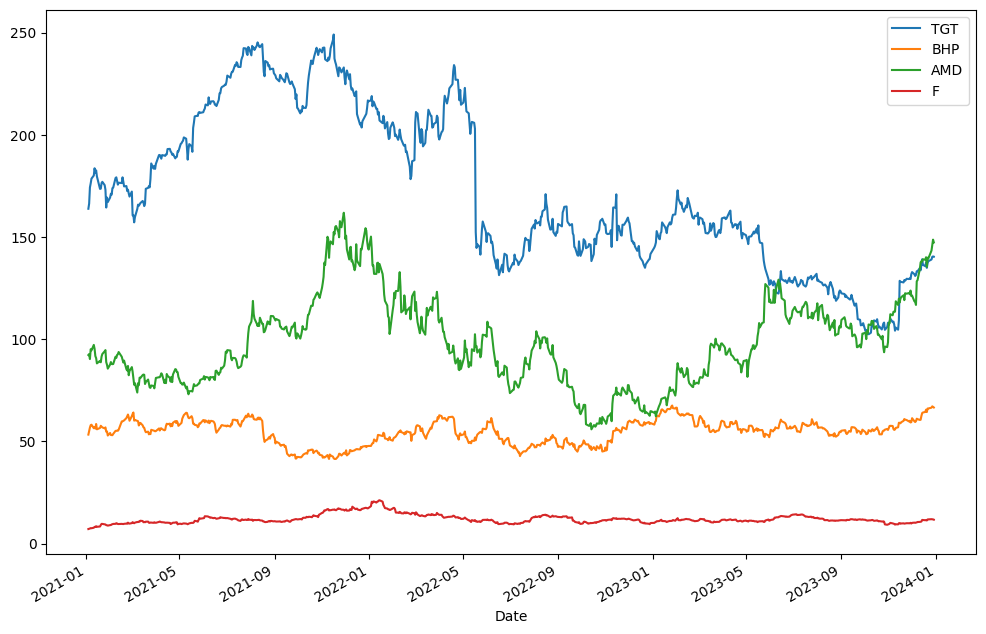

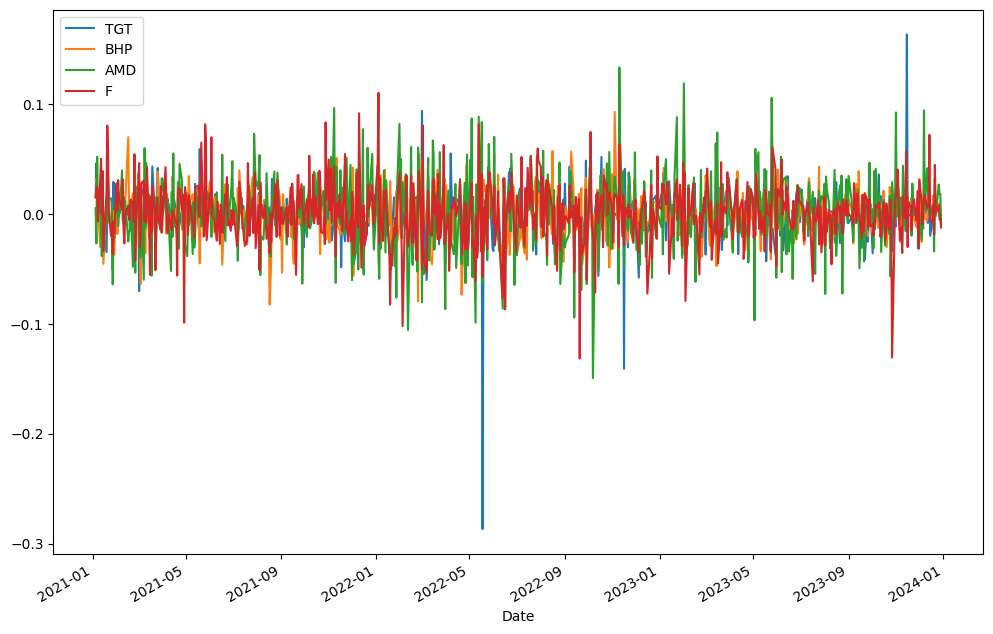

In [ ]:
stocks = ['TGT','BHP','AMD','F']
start_date = '2021-01-01'
end_date = '2024-01-01'

def download_data():
  market = {}
  for stock in stocks:
    ticker = yf.Ticker(stock)
    market[stock]=ticker.history(start=start_date,end=end_date)['Close']
  return pd.DataFrame(market)

def calculateReturns(data):
  log_return = np.log(data/data.shift(1))
  return pd.DataFrame(log_return)

market = download_data()
market.plot(figsize=(12,8))
plt.show()

returns = calculateReturns(market)
returns.plot(figsize=(12,8))
plt.show()

In [ ]:
from scipy.stats import norm
w = np.array([0.1,0.3,0.1,0.5])

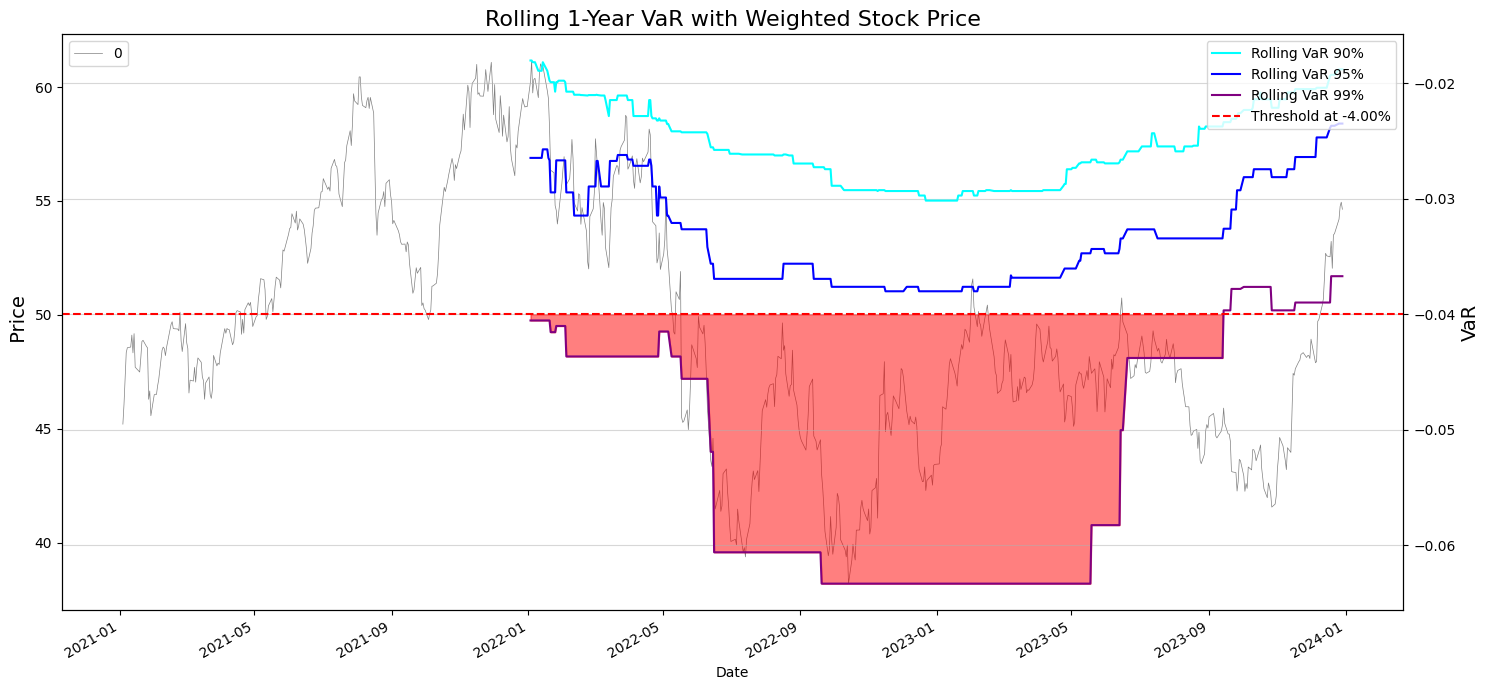

In [ ]:
rolling_var_90 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).quantile(0.10).dropna()
rolling_var_95 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).quantile(0.05).dropna()
rolling_var_99 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).quantile(0.01).dropna()

threshold = -0.04

plt.figure(figsize=(15,7))

# Plotting stock price
ax1 = plt.gca()
portf = pd.DataFrame(np.dot(w,market.T))
portf.set_index(returns.index,inplace=True)
portf.plot(ax=ax1, color='gray', linewidth=0.5, label='Portfolio Movement')
ax1.set_ylabel(' Price', fontsize=14)
ax1.legend(loc='upper left')

# Plotting VaR on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(rolling_var_90.index, rolling_var_90, label='Rolling VaR 90%', color='cyan', linewidth=1.5)
ax2.plot(rolling_var_95.index, rolling_var_95, label='Rolling VaR 95%', color='blue', linewidth=1.5)
ax2.plot(rolling_var_99.index, rolling_var_99, label='Rolling VaR 99%', color='purple', linewidth=1.5)

# Horizontal line to denote the threshold
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold at {threshold*100:.2f}%')

# Highlight areas below the threshold for 95% VaR
ax2.fill_between(rolling_var_99.index, rolling_var_99[0], threshold, where=(rolling_var_99[0] <= threshold), color='red', alpha=0.5)

# Aesthetics
ax2.set_ylabel('VaR', fontsize=14)
ax2.grid(True, alpha=0.5)
ax2.legend(loc='upper right')
plt.title('Rolling 1-Year VaR with Weighted Stock Price', fontsize=16)

plt.tight_layout()
plt.show()

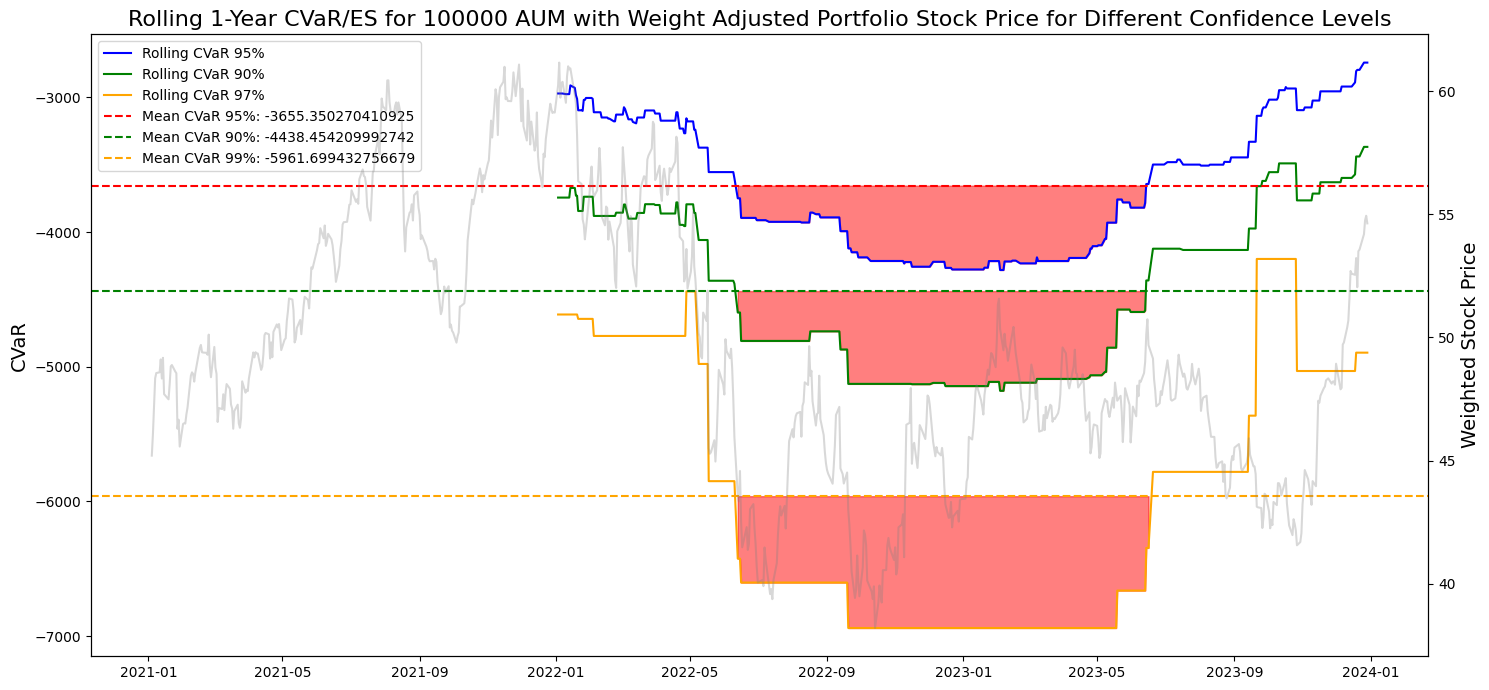

In [ ]:
portfolio_value = 100000

def conditional_var(x, alpha=0.05):
    var = np.percentile(x, alpha * 100)
    return np.mean(x[x < var])

rolling_cvar_90 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).apply(conditional_var, raw=True).dropna()
rolling_cvar_95 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).apply(lambda x: conditional_var(x, alpha=0.1), raw=True).dropna()
rolling_cvar_99 = pd.DataFrame(np.dot(w,returns.T),index=returns.index).rolling(252).apply(lambda x: conditional_var(x, alpha=0.01), raw=True).dropna()

mean_cvar_95 = rolling_cvar_95.mean()
mean_cvar_90 = rolling_cvar_90.mean()
mean_cvar_99 = rolling_cvar_99.mean()

plt.figure(figsize=(15,7))
ax1 = plt.gca()
ax1.plot(rolling_cvar_95*portfolio_value, label='Rolling CVaR 95%', linewidth=1.5, color='blue')
ax1.plot(rolling_cvar_90*portfolio_value, label='Rolling CVaR 90%', linewidth=1.5, color='green')
ax1.plot(rolling_cvar_99*portfolio_value, label='Rolling CVaR 97%', linewidth=1.5, color='orange')
ax1.axhline(y=mean_cvar_95[0]*portfolio_value, color='red', linestyle='--', label=f'Mean CVaR 95%: {mean_cvar_95[0]*portfolio_value}')
ax1.axhline(y=mean_cvar_90[0]*portfolio_value, color='green', linestyle='--', label=f'Mean CVaR 90%: {mean_cvar_90[0]*portfolio_value}')
ax1.axhline(y=mean_cvar_99[0]*portfolio_value, color='orange', linestyle='--', label=f'Mean CVaR 99%: {mean_cvar_99[0]*portfolio_value}')

ax1.set_title(f'Rolling 1-Year CVaR/ES for {portfolio_value} AUM with Weight Adjusted Portfolio Stock Price for Different Confidence Levels', fontsize=16)
ax1.set_ylabel('CVaR', fontsize=14)
ax1.legend()

ax1.fill_between(rolling_cvar_99.index, rolling_cvar_99[0]*portfolio_value, mean_cvar_99[0]*portfolio_value, where=(rolling_cvar_99[0] <= mean_cvar_99[0]), color='red', alpha=0.5)
ax1.fill_between(rolling_cvar_95.index, rolling_cvar_95[0]*portfolio_value, mean_cvar_95[0]*portfolio_value, where=(rolling_cvar_95[0] <= mean_cvar_95[0]), color='red', alpha=0.5)
ax1.fill_between(rolling_cvar_90.index, rolling_cvar_90[0]*portfolio_value, mean_cvar_90[0]*portfolio_value, where=(rolling_cvar_90[0] <= mean_cvar_90[0]), color='red', alpha=0.5)


ax3 = ax1.twinx()
portf = pd.DataFrame(np.dot(w,market.T))
portf.set_index(returns.index,inplace=True)
ax3.plot(portf, color='grey', alpha=0.3, label='Stock Price')
ax3.set_ylabel('Weighted Stock Price', fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
returns.cov()

,TGT,BHP,AMD,F
TGT,0.000506,0.000128,0.000221,0.000207
BHP,0.000128,0.000451,0.000204,0.000189
AMD,0.000221,0.000204,0.001025,0.000332
F,0.000207,0.000189,0.000332,0.000719


In [ ]:
def calc_parametric_var(window,returns,ci,w,portfolio_value):
    portfolio_returns = pd.DataFrame(np.dot(w,returns.T))
    yearly_avg_returns = portfolio_returns.rolling(window).sum().dropna()
    cov_matrix = returns.cov()*window
    portfolio_std = np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    parametric_var = (yearly_avg_returns.mean()-norm.ppf(ci)*portfolio_std)*portfolio_value
    return parametric_var
calc_parametric_var(252,returns,0.99,w,1000000)

0   -723680.588951
dtype: float64

In [ ]:
from scipy.stats import t
def t_calc_parametric_var(window,returns,ci,w,portfolio_value,dof=12):
    portfolio_returns = pd.DataFrame(np.dot(w,returns.T))
    yearly_avg_returns = portfolio_returns.rolling(window).sum().dropna()
    cov_matrix = returns.cov()*window
    portfolio_std = np.sqrt(np.dot(w.T,np.dot(cov_matrix,w)))
    parametric_var = (yearly_avg_returns.mean()-t.ppf(ci,dof)*portfolio_std)*portfolio_value
    return parametric_var
t_calc_parametric_var(54,returns,0.99,w,1000000,12)

0   -374684.875623
dtype: float64

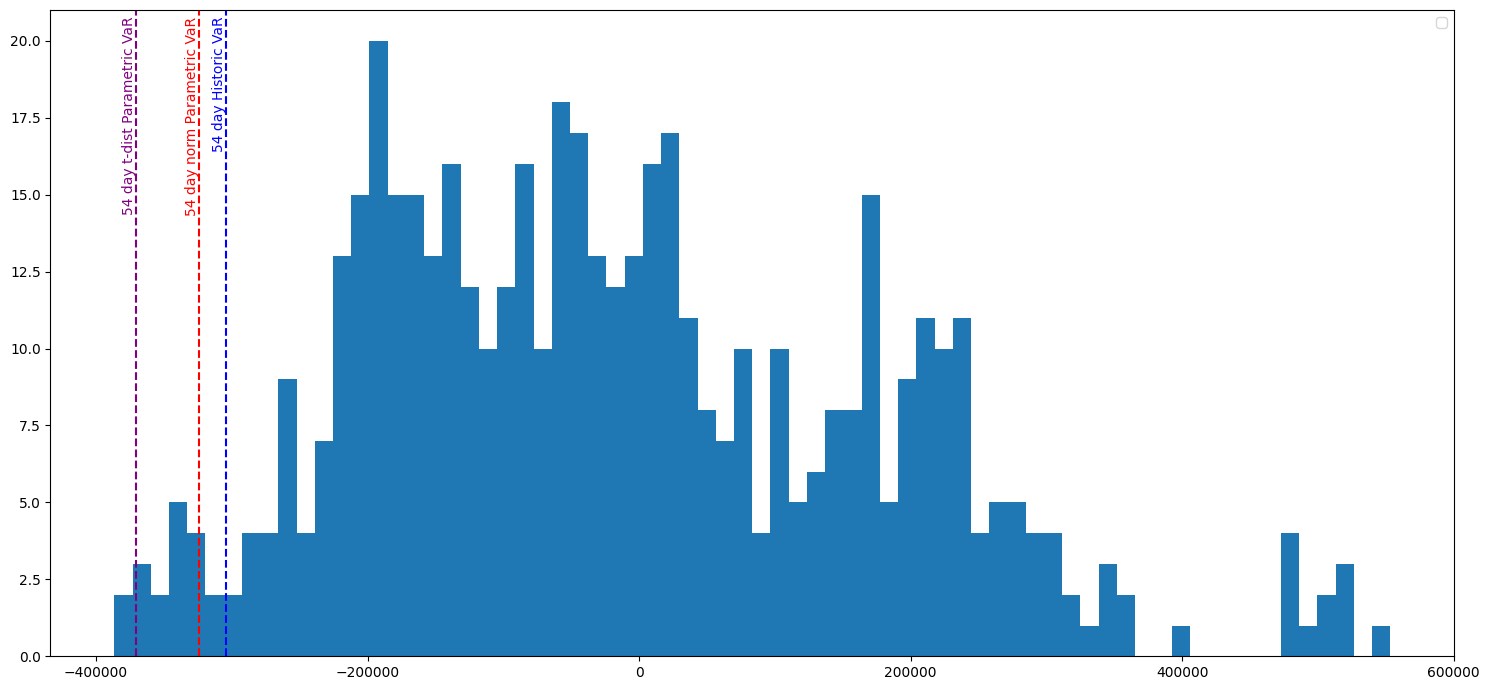

In [ ]:
portfolio_returns = np.dot(w,returns.T)
portfolio_returns = pd.DataFrame(portfolio_returns)
yearly_average = portfolio_returns.rolling(252).sum()
yearly_average = yearly_average.dropna()
yearly_average = yearly_average[0]
dx = (yearly_average.max()-yearly_average.min())/yearly_average.size
#bins = np.arange(yearly_average.min(),yearly_average.max(),dx)
mean_ret = yearly_average.mean()
portfolio_value=1000000
n_days = 54
par_var = calc_parametric_var(n_days,returns,0.99,w,1000000)
var_99 = (portfolio_returns.rolling(n_days).sum().quantile(0.01))*portfolio_value
t_var = t_calc_parametric_var(n_days,returns,0.99,w,1000000,13)
yearly_average_val = yearly_average*portfolio_value
fig, ax = plt.subplots(tight_layout=True,figsize=(15,7))
plt.hist(yearly_average_val,bins=70)
plt.axvline(x=par_var[0],color='r',linestyle="--")
ax.text(par_var[0], 0.99, f'{n_days} day norm Parametric VaR', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
plt.axvline(x=var_99[0],color='b',linestyle="--")
ax.text(var_99[0], 0.99, f'{n_days} day Historic VaR', color='b', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
plt.axvline(x=t_var[0],color='purple',linestyle="--")
ax.text(t_var[0], 0.99, f'{n_days} day t-dist Parametric VaR', color='purple', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
plt.legend()
plt.show()

[[-0.00020546 -0.00020546 -0.00020546 ... -0.00020546 -0.00020546
  -0.00020546]
 [ 0.0002952   0.0002952   0.0002952  ...  0.0002952   0.0002952
   0.0002952 ]
 [ 0.00062257  0.00062257  0.00062257 ...  0.00062257  0.00062257
   0.00062257]
 [ 0.00065844  0.00065844  0.00065844 ...  0.00065844  0.00065844
   0.00065844]]


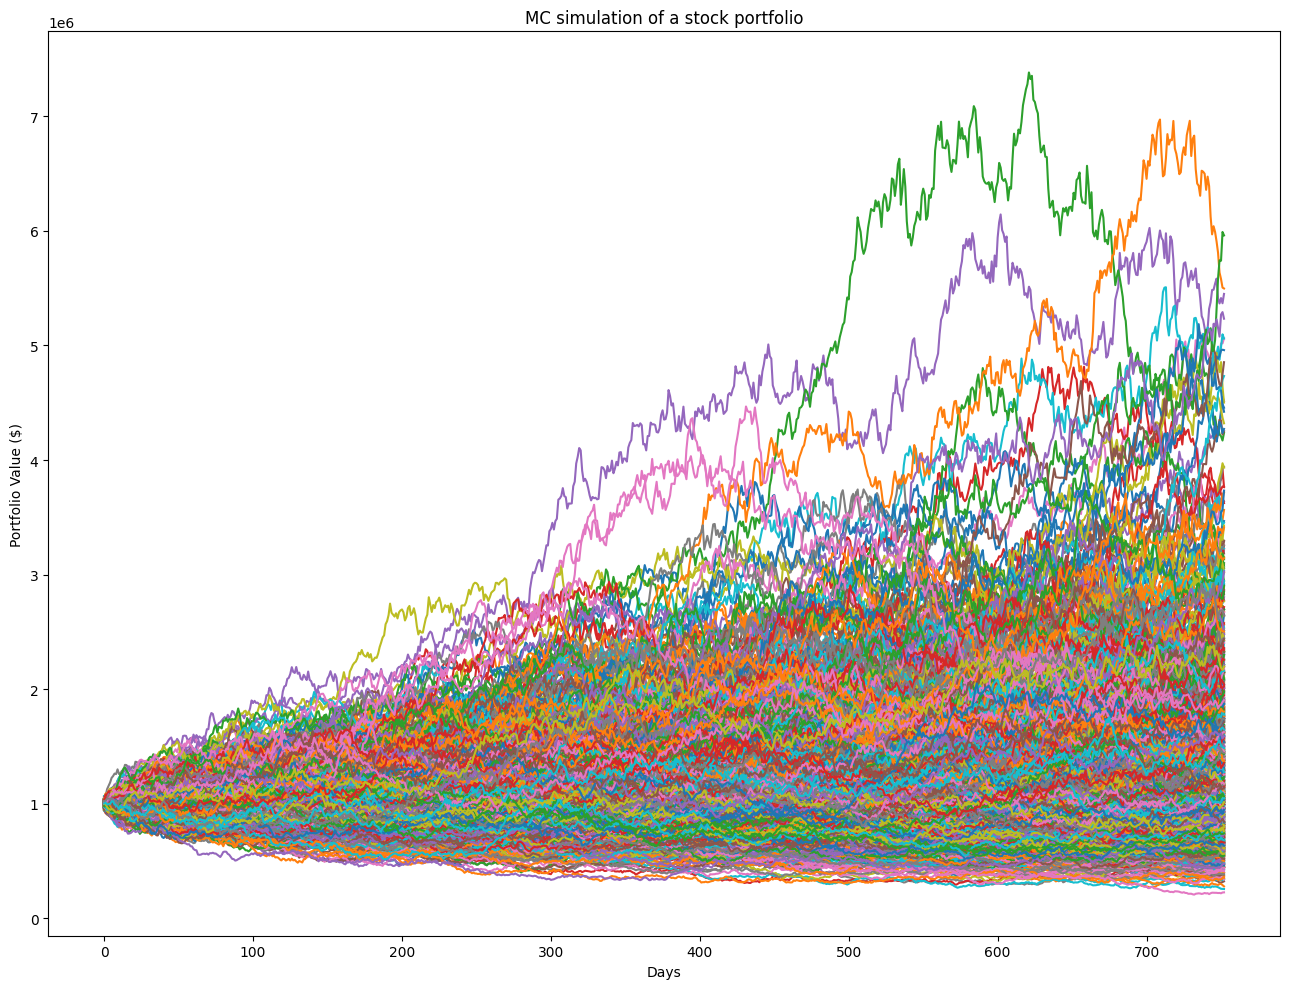

In [ ]:
simulations = 1000
days = returns.shape[0]
days

meanM = np.full(shape=(days,len(w)),fill_value=returns.mean())
meanMT = meanM.T
print(meanMT)

portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0)
cov_matrix = returns.cov()
for i in range(0,simulations):
    Z = np.random.normal(size=(days,len(w)))
    L = np.linalg.cholesky(cov_matrix)
    dailyRet = meanMT + np.inner(L,Z)
    portfolio_sims[:,i] = np.cumprod(np.inner(w, dailyRet.T)+1)*portfolio_value

fig, ax = plt.subplots(tight_layout=False,figsize=(13,10))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [ ]:
-np.percentile(portfolio_sims[-1:],1)

-334922.78619130683

# Credit Spread
Moody's 10-year AAA yield rates/US Treasure yield
    _from 2004 to 2024_ \\
Moody's 10-year BAA yield rates/US Treasure yield
    _from 2004 to 2024_

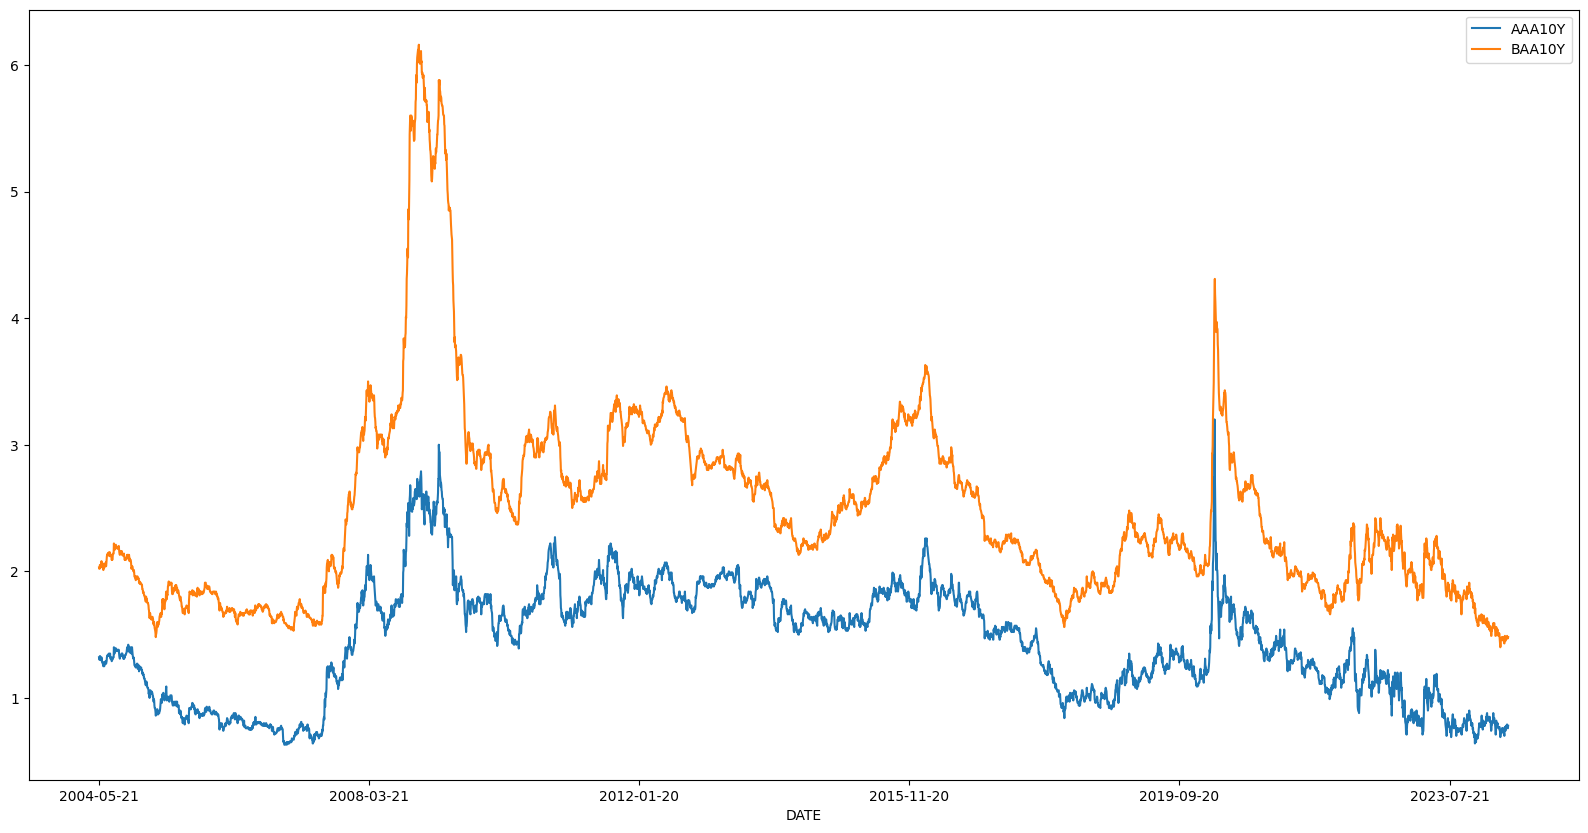

In [ ]:
aaa10 = pd.read_csv("AAA10Y.csv")
baa10 = pd.read_csv("BAA10Y.csv")
aaa10 = aaa10.set_index(aaa10['DATE'])
aaa10 = aaa10.drop(columns=['DATE'])
aaa10
baa10 = baa10.set_index(baa10['DATE'])
baa10 = baa10.drop(columns=['DATE'])
baa10

# plt.plot(aaa10['AAA10Y'])
# plt.plot(baa10['BAA10Y'])
aaa10['AAA10Y'] = pd.to_numeric(aaa10['AAA10Y'], errors='coerce')
baa10['BAA10Y'] = pd.to_numeric(baa10['BAA10Y'], errors='coerce')

aaa10 = aaa10.interpolate(method='linear')
baa10 = baa10.interpolate(method='linear')

aaa10['AAA10Y'].plot(figsize=(20,10), legend="AAA10Y over 10Y Treasury yield")
baa10['BAA10Y'].plot(figsize=(20,10), legend="BAA10Y over 10Y Treasury yield")
plt.legend(loc='upper right')
plt.show()

In [ ]:
def conditional_var(x, alpha=0.01):
    var = np.percentile(x, alpha * 100)
    return np.mean(x[x < var])


rolling_AAAcvar_99 = aaa10.rolling(5).apply(conditional_var, raw=True).dropna()
# rolling_BAAcvar_99 = baa10['BAA10Y'].rolling(24).apply(lambda x: conditional_var(x, alpha=0.01), raw=True).dropna()

mean_AAAcvar_99 = rolling_AAAcvar_99.mean()



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


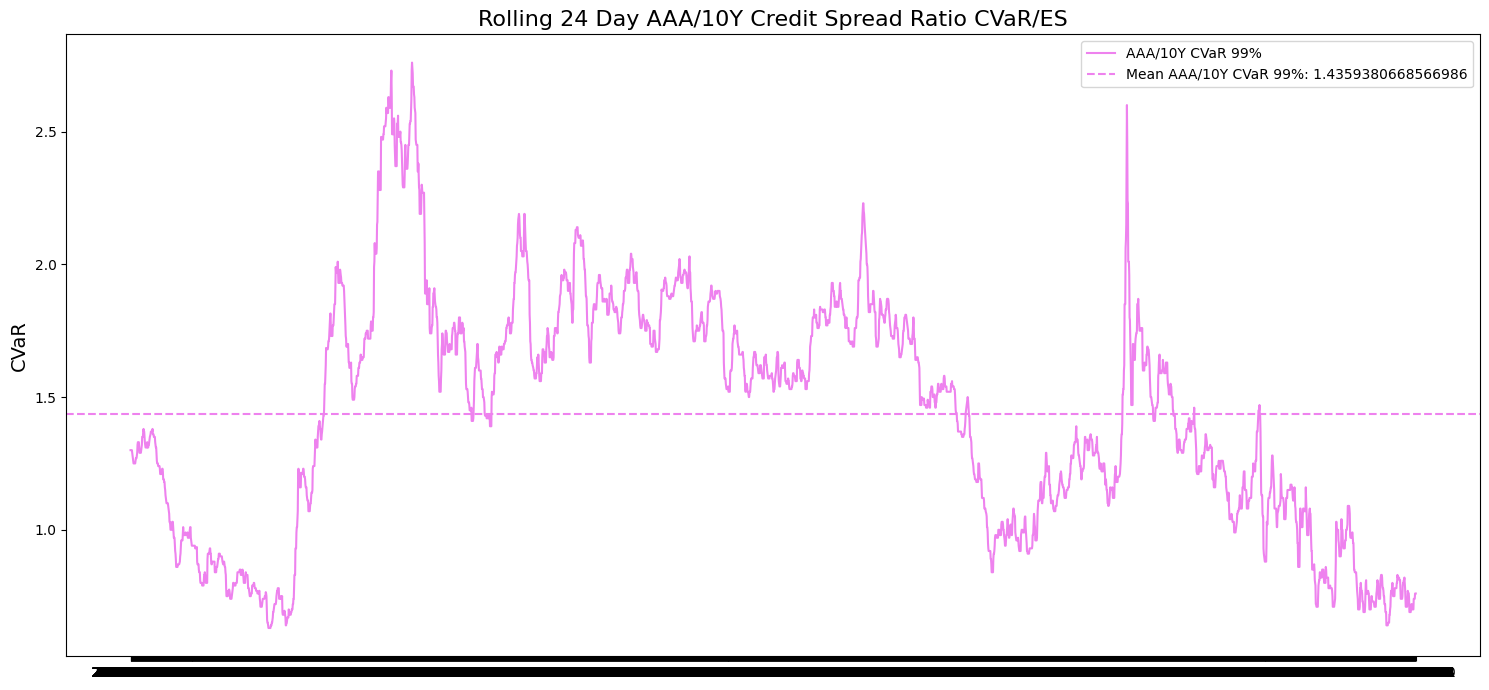

In [ ]:

plt.figure(figsize=(15,7))
ax1 = plt.gca()
ax1.plot(rolling_AAAcvar_99, label='AAA/10Y CVaR 99%', linewidth=1.5, color='violet')
# ax1.plot(rolling_BAAcvar_99, label='Rolling BAA/10Y CVaR 99%', linewidth=1.5, color='blue')
ax1.axhline(y=mean_AAAcvar_99[0], color='violet', linestyle='--', label=f'Mean AAA/10Y CVaR 99%: {mean_AAAcvar_99[0]}')
# ax1.axhline(y=mean_BAAcvar_99[0], color='blue', linestyle='--', label=f'Mean BAA/10Y CVaR 99%: {mean_BAAcvar_99[0]}')
# ax1.fill_between(rolling_AAAcvar_99.index, rolling_AAAcvar_99, mean_AAAcvar_99, where=(rolling_AAAcvar_99 >= mean_cvar_99), color='red', alpha=0.5)

ax1.set_title(f'Rolling 24 Day AAA/10Y Credit Spread Ratio CVaR/ES', fontsize=16)
ax1.set_ylabel('CVaR', fontsize=14)
ax1.legend()

plt.tight_layout()
plt.show()

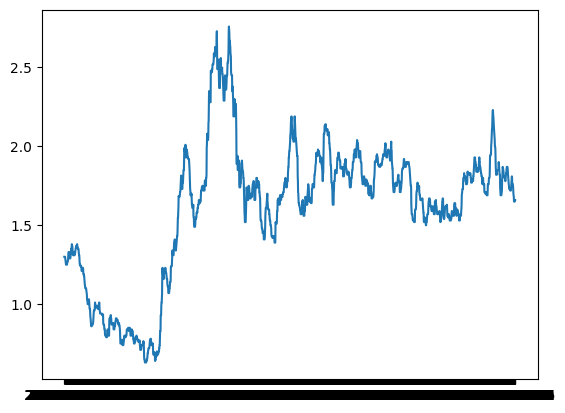

In [ ]:
train_size = int(0.6 * len(rolling_AAAcvar_99))
train_spreads = rolling_AAAcvar_99[:train_size]
test_spreads = rolling_AAAcvar_99[train_size:]
plt.plot(train_spreads)

In [ ]:
len(train_spreads)

2315

In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
train_spreads_ret = np.log(train_spreads/train_spreads.shift(1))

In [ ]:
from hmmlearn import hmm
hidden_regimes = 4
model = hmm.GaussianHMM(n_components=hidden_regimes, covariance_type="diag", n_iter=5000)
model.fit(train_spreads_ret[1:])

regime_probs = model.predict_proba(train_spreads_ret[1:])
hidden_states = model.predict(train_spreads_ret[1:])
print(regime_probs)

[[1.00000000e+000 2.25623024e-179 3.41593620e-239 9.35951514e-099]
 [9.22641199e-001 1.25525630e-002 8.69705110e-004 6.39365326e-002]
 [9.16627518e-001 1.42420917e-002 9.13956125e-004 6.82164345e-002]
 ...
 [9.11247151e-001 2.29587161e-002 1.26052690e-003 6.45336055e-002]
 [8.31338782e-001 2.94136088e-002 1.98463669e-003 1.37262972e-001]
 [8.90930598e-001 3.65400146e-002 2.22033975e-003 7.03090480e-002]]


In [ ]:
regime_probs

array([[8.10871523e-205, 1.54367468e-123, 1.00000000e+000,
        6.42358885e-073],
       [8.95170047e-004, 1.01029450e-002, 9.20986899e-001,
        6.80149860e-002],
       [9.49580895e-004, 1.23802361e-002, 9.16041112e-001,
        7.06290706e-002],
       ...,
       [1.26677652e-003, 1.94687745e-002, 9.11783688e-001,
        6.74807614e-002],
       [2.06162573e-003, 2.52980295e-002, 8.29553988e-001,
        1.43086356e-001],
       [2.26534931e-003, 3.14312188e-002, 8.92236430e-001,
        7.40670017e-002]])

In [ ]:
import tensorflow as tf
import keras
from keras import layers

# Markov RNN

![NTMCell.png](attachment:NTMCell.png)

In [ ]:
#regimes = 4
np.random.seed(1213)

# CVaR_t-1 and regime_t-1 as forward input
i_weight = np.random.rand(2,2)
h_weight = np.random.rand(2,2)
h_bias = np.random.rand(1,2)

#extra layers for regime specific models

#input for each is prob of that regime from transition matrix and w_h*x_h and w_i*x_i
# [W_x_i,W_x_h[0],W_x_h[1]]
r1_weight = np.random.rand(4,1) #no of outputs: prediction,regime
r1_bias = np.random.rand(1,1)
r2_weight = np.random.rand(4,1)
r2_bias = np.random.rand(1,1)
r3_weight = np.random.rand(4,1)
r3_bias = np.random.rand(1,1)
r4_weight = np.random.rand(4,1)
r4_bias = np.random.rand(1,1)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x),axis=0)


def tanh(x):
    return np.tanh(x-1)
# customized tan-h like activation function for our data

def swish(x):
    return x*np.exp(x)/(1+np.exp(x))

#selection_layer:
s_weight = np.random.rand(8,1)
s_bias = np.random.rand(1,1)

o_weight = np.random.rand(1,1)
o_bias = np.random.rand(1,1)



x_i0 = [1.3,2]
x_h0 = [3.2,1]

print(x_i0 @ i_weight)
print(x_h0 @ h_weight)

[2.29070103 2.95674979]
[2.85038722 1.97307738]


-0.46211715726000974

In [ ]:
x_i0 = init_input @ i_weight
x_i0

In [ ]:
x_h0 = (x_i0 + prev_layer_h @ h_weight + h_bias).reshape(2)
x_h0

In [ ]:
trans_prob[0]

In [ ]:
x_h0 = tanh(np.array(x_h0))

In [ ]:
intermediate_input_1 = [*x_i0,*x_h0]
intermediate_input_2 = [*x_i0,*x_h0]
intermediate_input_3 = [*x_i0,*x_h0]
intermediate_input_4 = [*x_i0,*x_h0]
print(intermediate_input_1)

In [ ]:
intermediate_output_1 = (intermediate_input_1 @ r1_weight + r1_bias).reshape(1)
print(intermediate_output_1)
intermediate_output_2 = (intermediate_input_2 @ r2_weight + r2_bias).reshape(1)
print(intermediate_output_2)
intermediate_output_3 = (intermediate_input_3 @ r3_weight + r3_bias).reshape(1)
print(intermediate_output_3)
intermediate_output_4 = (intermediate_input_4 @ r4_weight + r4_bias).reshape(1)
print(intermediate_output_4)

In [ ]:
activated_int_output_1 = swish(intermediate_output_1)
activated_int_output_2 = swish(intermediate_output_2)
activated_int_output_3 = swish(intermediate_output_3)
activated_int_output_4 = swish(intermediate_output_4)
print(activated_int_output_1)

In [ ]:
selection_input = [*activated_int_output_1,
                   *activated_int_output_2,
                   *activated_int_output_3,
                   *activated_int_output_4,
                   *trans_prob
                   ]

print(selection_input)

In [ ]:
selection_output = (selection_input @ s_weight + s_bias).reshape(1)
activated_sel_output = tanh(selection_output)
print(activated_sel_output)

In [ ]:
np.maximum(0,activated_sel_output)

In [ ]:
final_output = (activated_sel_output @ o_weight + o_bias).reshape(1)
final_output

In [ ]:
trans_prob_t =  model.predict_proba(final_output.reshape(-1,1))
regime_t = model.predict(final_output.reshape(-1,1))
print(trans_prob)
print(regime)

In [ ]:
prev_hidden = [*x_h0,*regime_t]
prev_hidden

In [ ]:
rolling_AAAcvar_99*1000

,AAA10Y
DATE,
2004-05-27,1300.0
2004-05-28,1300.0
2004-05-31,1300.0
2004-06-02,1300.0
2004-06-03,1300.0
...,...
2024-05-10,740.0
2024-05-13,740.0
2024-05-14,760.0


In [ ]:
sequence = train_spreads['AAA10Y'].to_numpy()
sequence
mini_sequence = sequence[:201]
mini_sequence
mini_sequence_train = pd.DataFrame(mini_sequence).shift(1)
mini_sequence_train = np.array(mini_sequence_train[1:])
len(mini_sequence_train)

200

In [ ]:
actual_outputs = train_spreads['AAA10Y'].to_numpy()
len(actual_outputs)

2315

In [ ]:
test_spreads

,AAA10Y
DATE,
2016-09-07,1.67
2016-09-08,1.68
2016-09-09,1.69
2016-09-12,1.70
2016-09-13,1.74
...,...
2024-05-10,0.74
2024-05-13,0.74
2024-05-14,0.76


In [ ]:
reg = model.predict(test_spreads)
reg

array([0, 0, 0, ..., 0, 0, 0])

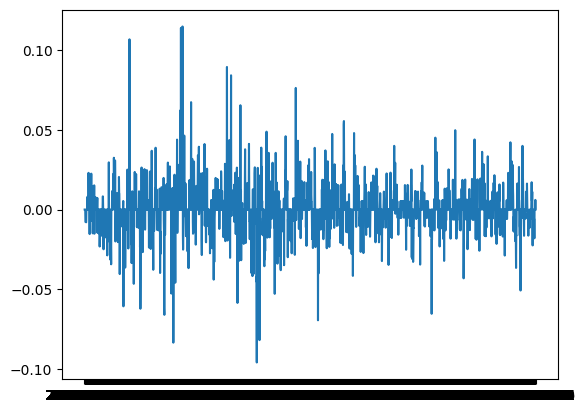

In [ ]:
train_spreads_ret = np.log(train_spreads/train_spreads.shift(1))
plt.plot(train_spreads_ret)

In [ ]:
regime_probs.shape

(2314, 4)

In [ ]:
train_spreads_ret_n = train_spreads_ret[1:]
train_spreads_ret_n.shape

(2314, 1)

In [ ]:
np.array(train_spreads_ret_n)

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.00604231],
       [0.        ]])

Full Forward Pass

In [ ]:
import math

hiddens = []
outputs = []

def forward(inp):

    prev_hidden = None
    prev_ans = None
    outputs = np.zeros(len(inp))
    hiddens = np.zeros((len(inp),2))


    for i in range(0,len(inp),1):

        x = inp[i]
        reg = 0
        if i <= 0:
            prev_prev = 1
        else:
            prev_prev = inp[i-1]

        ret=0

        if prev_ans is None:
            reg = 0
        else:
            if prev_prev == 0:
              ret = 10
            else:
              ret = np.log(prev_ans/prev_prev)
              if math.isnan(ret[0]):
                reg = 0
              else:
                reg = model.predict(ret.reshape(-1,1)).flatten()

        x  = np.append(x,reg)
        x_i = (x @ i_weight)
        #print(x_i)
        if prev_hidden is None:
            x_h = x_i
        else:
            x_h = ( x_i + prev_hidden @ h_weight + h_bias).reshape(2)

        x_h = tanh(np.array(x_h))

        prev_hidden = x_h
        #print(x_h)

        intermediate_input_1 = [*x_i,*x_h]
        intermediate_input_2 = [*x_i,*x_h]
        intermediate_input_3 = [*x_i,*x_h]
        intermediate_input_4 = [*x_i,*x_h]

    # print(intermediate_input_1)

        intermediate_output_2 = (intermediate_input_2 @ r2_weight + r2_bias).reshape(1)
        intermediate_output_1 = (intermediate_input_1 @ r1_weight + r1_bias).reshape(1)
        intermediate_output_3 = (intermediate_input_3 @ r3_weight + r3_bias).reshape(1)
        intermediate_output_4 = (intermediate_input_4 @ r4_weight + r4_bias).reshape(1)
        #print(intermediate_output_4)

        activated_int_output_1 = tanh(intermediate_output_1)
        activated_int_output_2 = tanh(intermediate_output_2)
        activated_int_output_3 = tanh(intermediate_output_3)
        activated_int_output_4 = tanh(intermediate_output_4)

        if prev_ans is None:
            trans_prob = np.random.rand(1,4)
            trans_prob = trans_prob/np.sum(trans_prob)

        else:
            if math.isnan(prev_ans[0]):
              trans_prob = np.random.rand(1,4)
              trans_prob = trans_prob/np.sum(trans_prob)
            else:
              trans_prob = model.predict_proba(prev_ans[0].reshape(-1,1))

        trans_prob = np.array(trans_prob,dtype="object")
        selection_input = [*activated_int_output_1,
                    *activated_int_output_2,
                    *activated_int_output_3,
                    *activated_int_output_4,
                    *trans_prob[0]
                    ]

        selection_input = np.array(selection_input)

        selection_output = (selection_input @ s_weight + s_bias).reshape(1)
        activated_sel_output = tanh(selection_output)

        final_output = (activated_sel_output @ o_weight + o_bias).reshape(1)

        prev_ans = final_output
        #model is a pretrained HMM

        prev_hidden = x_h

        hiddens[i,] = x_h


        outputs[i] = final_output[0]

    return outputs, activated_sel_output,selection_output,selection_input,activated_int_output_1,activated_int_output_2,activated_int_output_3,activated_int_output_4,hiddens,x_i



In [ ]:
actual_outputs = train_spreads
train_spreads_n = actual_outputs.shift(1)[1:]
actual_outputs = actual_outputs[1:]
print(len(actual_outputs))
train_spreads_n

2314


,AAA10Y
DATE,
2004-05-28,1.30
2004-05-31,1.30
2004-06-02,1.30
2004-06-03,1.30
2004-06-04,1.30
...,...
2016-08-31,1.65
2016-09-01,1.65
2016-09-02,1.65


In [ ]:
# #scaling up
# actual_outputs = actual_outputs*10000
# train_spreads_n = train_spreads_n*10000

# actual_outputs

,AAA10Y
DATE,
2004-05-28,130000000.0
2004-05-31,130000000.0
2004-06-02,130000000.0
2004-06-03,130000000.0
2004-06-04,129000000.0
...,...
2016-08-31,165000000.0
2016-09-01,165000000.0
2016-09-02,165000000.0


In [ ]:
outputs,activated_sel_output,selection_output,selection_input,activated_int_output_1,activated_int_output_2,activated_int_output_3,activated_int_output_4,hiddens,x_i = forward(np.array(train_spreads_n))
len(outputs)
outputs

array([0.40700754, 0.49157235, 0.49170758, ..., 0.49185189, 0.49185189,
       0.49185561])

Backward Pass

In [ ]:
def mse(actual,predicted):
    return np.mean((actual-predicted)**2)

def grad_mse(actual,predicted):
    return (predicted-actual)

In [ ]:
train_spreads_n.shape

(2314, 1)

In [ ]:
a1 = [1,2,3,44,5]
a2 = [12,4,124,22,5]

grad_mse(np.array(train_spreads_n),np.array(actual_outputs))

array([[0.  ],
       [0.  ],
       [0.  ],
       ...,
       [0.  ],
       [0.01],
       [0.  ]])

In [ ]:
def tanh_derivative(x):
    return 1 - np.tanh(x-1)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish_derivative(x):
    sigma_x = sigmoid(x)
    return sigma_x * (1 + x * (1 - sigma_x))

In [ ]:
tanh_derivative(10)

6.091991733292446e-08

In [ ]:
def backward(inp,  targets, learning_rate, wts):
    i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias = wts
    d_i_weight = np.zeros_like(i_weight)
    d_h_weight = np.zeros_like(h_weight)
    d_h_bias = np.zeros_like(h_bias)
    d_r1_weight = np.zeros_like(r1_weight)
    d_r1_bias = np.zeros_like(r1_bias)
    d_r2_weight = np.zeros_like(r2_weight)
    d_r2_bias = np.zeros_like(r2_bias)
    d_r3_weight = np.zeros_like(r3_weight)
    d_r3_bias = np.zeros_like(r3_bias)
    d_r4_weight = np.zeros_like(r4_weight)
    d_r4_bias = np.zeros_like(r4_bias)
    d_s_weight = np.zeros_like(s_weight)
    d_s_bias = np.zeros_like(s_bias)
    d_o_weight = np.zeros_like(o_weight)
    d_o_bias = np.zeros_like(o_bias)



    outputs, activated_sel_output,selection_output,selection_input,activated_int_output_1,activated_int_output_2,activated_int_output_3,activated_int_output_4,hiddens,x_i = forward(inp)

    outputs = outputs.reshape(targets.shape)
    loss_grad = grad_mse(targets,outputs)
    print(loss_grad)
    next_hidden = None

    d_final_output = np.zeros_like(outputs)
    d_hiddens = np.zeros_like(hiddens)

    for t in reversed(range(len(inp))):

        l_grad = loss_grad[t].reshape(1,1)

        d_o_weight += activated_sel_output[:,np.newaxis] @ l_grad
        d_o_bias += np.mean(l_grad)

        o_grad = l_grad @ o_weight.T

        ac_s_grad = np.multiply(o_grad,tanh_derivative(selection_output))

        d_s_weight += selection_input[:,np.newaxis] @ ac_s_grad
        d_s_bias += np.mean(ac_s_grad)

        s_grad = o_grad @ s_weight.T

        d_r1_weight += activated_int_output_1[:,np.newaxis] @ s_grad[0][:1]
        d_r1_bias += np.mean(s_grad[0][:1])

        d_r2_weight += activated_int_output_2[:,np.newaxis] @ s_grad[0][1:2]
        d_r2_bias += np.mean(s_grad[0][1:2])

        d_r3_weight += activated_int_output_3[:,np.newaxis] @ s_grad[0][2:3]
        d_r3_bias += np.mean(s_grad[0][2:3])

        d_r4_weight += activated_int_output_4[:,np.newaxis] @ s_grad[0][3:4]
        d_r4_bias += np.mean(s_grad[0][3:4])

        r1_grad = s_grad[0][0:1] @ r1_weight.T
        r2_grad = s_grad[0][1:2] @ r2_weight.T
        r3_grad = s_grad[0][2:3] @ r3_weight.T
        r4_grad = s_grad[0][3:4] @ r4_weight.T

        r_grad = r1_grad+r2_grad+r3_grad+r4_grad

        if next_hidden is None:
            h_grad = r_grad[2:4]
        else:
            # print(f"r_grad: {t} : {r_grad[2:4]}")
            # print(f"next_hidden: {t} :{next_hidden}")
            # print(f"h_weight : {t} : {h_weight.T}")
            h_grad = r_grad[2:4] + next_hidden @ h_weight.T

        h_grad = np.multiply(h_grad,tanh_derivative(hiddens[t,:][np.newaxis,:]))
        next_hidden = h_grad

        if t>0:
            d_h_weight += hiddens[t-1,:][:,np.newaxis] @ h_grad
            d_h_bias += np.mean(h_grad)

        d_i_weight += x_i.T @ r_grad[0:2]


    i_weight -= learning_rate * d_i_weight
    h_weight -= learning_rate * d_h_weight
    h_bias -= learning_rate * d_h_bias
    r1_weight -= learning_rate * d_r1_weight
    r1_bias -= learning_rate * d_r1_bias
    r2_weight -= learning_rate * d_r2_weight
    r2_bias -= learning_rate * d_r2_bias
    r3_weight -= learning_rate * d_r3_weight
    r3_bias -= learning_rate * d_r3_bias
    r4_weight -= learning_rate * d_r4_weight
    r4_bias -= learning_rate * d_r4_bias
    s_weight -= learning_rate * d_s_weight
    s_bias -= learning_rate * d_s_bias
    o_weight -= learning_rate * d_o_weight
    o_bias -= learning_rate * d_o_bias

    return i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias

In [ ]:
def train_model(train_data, targets, epochs, learning_rate):
    weights = [i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias]
    for epoch in range(epochs):
        weightsnew = backward(train_data, targets, learning_rate,weights)
        weights = weightsnew


In [ ]:
epochs = 200
learning_rate = 0.0001
weights = [i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias]
for epoch in range(epochs):
    weightsnew = backward(np.array(train_spreads_n), np.array(actual_outputs), learning_rate,weights)
    weights = weightsnew

[[-0.89523085]
 [-0.80842765]
 [-0.80829242]
 ...
 [-1.15814811]
 [-1.16814811]
 [-1.16814439]]
[[-0.68184051]
 [-0.47805316]
 [-0.4741169 ]
 ...
 [-0.8271866 ]
 [-0.8371866 ]
 [-0.83716395]]


<ipython-input-44-fdd77b3d952e>:72: RuntimeWarning: overflow encountered in matmul
  h_grad = r_grad[2:4] + next_hidden @ h_weight.T
<ipython-input-44-fdd77b3d952e>:78: RuntimeWarning: invalid value encountered in add
  d_h_weight += hiddens[t-1,:][:,np.newaxis] @ h_grad


[[-0.32139797]
 [        nan]
 [        nan]
 ...
 [        nan]
 [        nan]
 [        nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]


KeyboardInterrupt: 

In [ ]:
weights

(array([[0.70411349, 1.31117614],
        [1.32342313, 1.26185678]]),
 array([[ 0.28838308,  0.18976172],
        [-0.00738442,  0.81986464]]),
 array([[0.10338561, 0.49305772]]),
 array([[0.7525626 ],
        [0.24373216],
        [0.71614749],
        [0.88391717]]),
 array([[0.7982242]]),
 array([[0.48194899],
        [0.4376123 ],
        [0.23785492],
        [0.92804683]]),
 array([[0.48039094]]),
 array([[0.4092235 ],
        [0.68126937],
        [0.26094826],
        [0.09366471]]),
 array([[0.62264873]]),
 array([[0.56068542],
        [0.06293943],
        [0.39834768],
        [0.17393494]]),
 array([[0.60448165]]),
 array([[0.52552509],
        [0.15786069],
        [0.07942141],
        [0.2690068 ],
        [0.13665697],
        [0.5855869 ],
        [0.42315465],
        [0.99238938]]),
 array([[0.27098622]]),
 array([[0.60441219]]),
 array([[1.10042945]]))

In [ ]:
outputs,activated_sel_output,selection_output,selection_input,activated_int_output_1,activated_int_output_2,activated_int_output_3,activated_int_output_4,hiddens,x_i = forward(np.array(train_spreads_n))
outputs

array([1.36461319, 1.57656371, 1.57798856, ..., 1.59828341, 1.59828194,
       1.59862022])

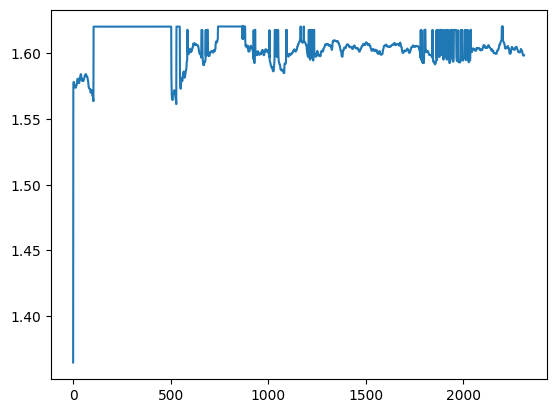

In [ ]:
plt.plot(outputs)

In [ ]:
op_frame = pd.DataFrame(outputs)
op_frame.set_index(actual_outputs.index,inplace=True)

In [ ]:
def predict(horizon):

  i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias = weights
  x_initial = np.array(train_spreads_n)[-1][0]
  inp = np.zeros(horizon)
  print(len(inp))
  inp[0]=x_initial
  prev_hidden = None
  prev_ans = None
  forecasts = np.zeros(len(inp))
  hiddens = np.zeros((len(inp),2))

  for i in range(0,len(inp),1):

        x = inp[i]
        reg = 0
        if i <= 0:
            prev_prev = 1
        else:
            prev_prev = inp[i-1]

        ret=0

        if prev_ans is None:
            reg = 0
        else:
            if prev_prev == 0:
              ret = 10
            else:
              ret = np.log(prev_ans/prev_prev)
              if math.isnan(ret[0]):
                reg = 0
              else:
                reg = model.predict(ret.reshape(-1,1)).flatten()

        x  = np.append(x,reg)
        x_i = (x @ i_weight)
        #print(x_i)
        if prev_hidden is None:
            x_h = x_i
        else:
            x_h = ( x_i + prev_hidden @ h_weight + h_bias).reshape(2)

        x_h = tanh(np.array(x_h))

        prev_hidden = x_h
        #print(x_h)

        intermediate_input_1 = [*x_i,*x_h]
        intermediate_input_2 = [*x_i,*x_h]
        intermediate_input_3 = [*x_i,*x_h]
        intermediate_input_4 = [*x_i,*x_h]

    # print(intermediate_input_1)

        intermediate_output_2 = (intermediate_input_2 @ r2_weight + r2_bias).reshape(1)
        intermediate_output_1 = (intermediate_input_1 @ r1_weight + r1_bias).reshape(1)
        intermediate_output_3 = (intermediate_input_3 @ r3_weight + r3_bias).reshape(1)
        intermediate_output_4 = (intermediate_input_4 @ r4_weight + r4_bias).reshape(1)
        #print(intermediate_output_4)

        activated_int_output_1 = tanh(intermediate_output_1)
        activated_int_output_2 = tanh(intermediate_output_2)
        activated_int_output_3 = tanh(intermediate_output_3)
        activated_int_output_4 = tanh(intermediate_output_4)

        if prev_ans is None:
            trans_prob = np.random.rand(1,4)
            trans_prob = trans_prob/np.sum(trans_prob)

        else:
            if math.isnan(prev_ans[0]):
              trans_prob = np.random.rand(1,4)
              trans_prob = trans_prob/np.sum(trans_prob)
            else:
              trans_prob = model.predict_proba(prev_ans[0].reshape(-1,1))

        trans_prob = np.array(trans_prob,dtype="object")
        selection_input = [*activated_int_output_1,
                    *activated_int_output_2,
                    *activated_int_output_3,
                    *activated_int_output_4,
                    *trans_prob[0]
                    ]

        selection_input = np.array(selection_input)

        selection_output = (selection_input @ s_weight + s_bias).reshape(1)
        activated_sel_output = tanh(selection_output)

        final_output = (activated_sel_output @ o_weight + o_bias).reshape(1)

        prev_ans = final_output
        #model is a pretrained HMM

        prev_hidden = x_h

        hiddens[i,] = x_h


        forecasts[i] = final_output[0]

        if(i!=len(inp)-1):
          inp[i+1] = forecasts[i]

  return forecasts




In [ ]:
forecasts = predict(400)

400


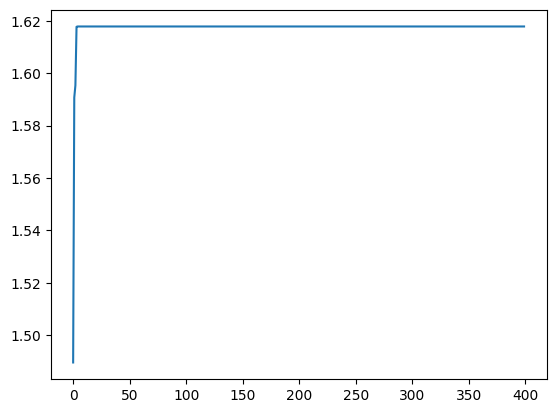

In [ ]:
plt.plot(forecasts)

In [ ]:
forecasts

array([1.48958039, 1.59073628, 1.5953758 , 1.6177335 , 1.6178478 ,
       1.6178496 , 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784965,
       1.61784965, 1.61784965, 1.61784965, 1.61784965, 1.61784

# Streamlining

In [ ]:
import math
import numpy as np

def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1 / math.sqrt(2)
        i_weight = np.random.rand(2, 2) * 2 * k - k

        h_weight = np.random.rand(2, 2) * 2 * k - k
        h_bias = np.random.rand(1, 2) * 2 * k - k

        r1_weight = np.random.rand(4, 1) * 2 * k - k
        r1_bias = np.random.rand(1, 1) * 2 * k - k

        r2_weight = np.random.rand(4, 1) * 2 * k - k
        r2_bias = np.random.rand(1, 1) * 2 * k - k

        r3_weight = np.random.rand(4, 1) * 2 * k - k
        r3_bias = np.random.rand(1, 1) * 2 * k - k

        r4_weight = np.random.rand(4, 1) * 2 * k - k
        r4_bias = np.random.rand(1, 1) * 2 * k - k

        s_weight = np.random.rand(8, 1) * 2 * k - k
        s_bias = np.random.rand(1, 1) * 2 * k - k

        o_weight = np.random.rand(1, 1) * 2 * k - k
        o_bias = np.random.rand(1, 1) * 2 * k - k

        layers.append([i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias,
                       r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias])

    return layers


In [ ]:

def forward(inp, layers, model):
    hiddens = []
    outputs = []
    for layer in layers:
        i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias = layer
        prev_hidden = None
        prev_ans = None
        layer_outputs = np.zeros(len(inp))
        layer_hiddens = np.zeros((len(inp), layer[1].shape[1]))

        for i in range(len(inp)):
            x = inp[i]
            reg = 0
            if i <= 0:
                prev_prev = 1
            else:
                prev_prev = inp[i-1]

            ret=0

            if prev_ans is None:
                reg = 0
            else:
                if prev_prev == 0:
                  ret = 10
                else:
                  if prev_ans == 0:
                    ret =0
                    break

                  ret = np.log(prev_ans/prev_prev)
                  if math.isnan(ret[0]):
                    reg = 0
                  else:
                    reg = model.predict(ret.reshape(-1,1)).flatten()

            x  = np.append(x,reg)
            x_i = (x @ i_weight)
            #print(x_i)
            if prev_hidden is None:
                x_h = x_i
            else:
                x_h = ( x_i + prev_hidden @ h_weight + h_bias).reshape(2)

            x_h = tanh(np.array(x_h))

            prev_hidden = x_h
            #print(x_h)

            intermediate_input_1 = [*x_i,*x_h]
            intermediate_input_2 = [*x_i,*x_h]
            intermediate_input_3 = [*x_i,*x_h]
            intermediate_input_4 = [*x_i,*x_h]

        # print(intermediate_input_1)

            intermediate_output_2 = (intermediate_input_2 @ r2_weight + r2_bias).reshape(1)
            intermediate_output_1 = (intermediate_input_1 @ r1_weight + r1_bias).reshape(1)
            intermediate_output_3 = (intermediate_input_3 @ r3_weight + r3_bias).reshape(1)
            intermediate_output_4 = (intermediate_input_4 @ r4_weight + r4_bias).reshape(1)
            #print(intermediate_output_4)

            activated_int_output_1 = tanh(intermediate_output_1)
            activated_int_output_2 = tanh(intermediate_output_2)
            activated_int_output_3 = tanh(intermediate_output_3)
            activated_int_output_4 = tanh(intermediate_output_4)

            if prev_ans is None:
                trans_prob = np.random.rand(1,4)
                trans_prob = trans_prob/np.sum(trans_prob)

            else:
                if math.isnan(prev_ans[0]):
                  trans_prob = np.random.rand(1,4)
                  trans_prob = trans_prob/np.sum(trans_prob)
                else:
                  trans_prob = model.predict_proba(prev_ans[0].reshape(-1,1))

            trans_prob = np.array(trans_prob,dtype="object")
            selection_input = [*activated_int_output_1,
                        *activated_int_output_2,
                        *activated_int_output_3,
                        *activated_int_output_4,
                        *trans_prob[0]
                        ]

            selection_input = np.array(selection_input)

            selection_output = (selection_input @ s_weight + s_bias).reshape(1)
            activated_sel_output = tanh(selection_output)

            final_output = (activated_sel_output @ o_weight + o_bias).reshape(1)

            prev_ans = final_output
            layer_hiddens[i, :] = x_h
            layer_outputs[i] = final_output

        hiddens.append(layer_hiddens)

In [ ]:
def backward(inp, targets, learning_rate, layers, model):
    outputs, activated_sel_output, selection_output, selection_input, activated_int_output_1, activated_int_output_2, activated_int_output_3, activated_int_output_4, hiddens, x_i = forward(inp, layers, model)
    outputs = outputs.reshape(targets.shape)
    loss_grad = grad_mse(targets, outputs)

    for layer in layers:
        i_weight, h_weight, h_bias, r1_weight, r1_bias, r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias, o_weight, o_bias = layer

        d_i_weight = np.zeros_like(i_weight)
        d_h_weight_1 = np.zeros_like(h_weight)
        d_h_bias_1 = np.zeros_like(h_bias)
        d_r1_weight = np.zeros_like(r1_weight)
        d_r1_bias = np.zeros_like(r1_bias)
        d_r2_weight = np.zeros_like(r2_weight)
        d_r2_bias = np.zeros_like(r2_bias)
        d_r3_weight = np.zeros_like(r3_weight)
        d_r3_bias = np.zeros_like(r3_bias)
        d_r4_weight = np.zeros_like(r4_weight)
        d_r4_bias = np.zeros_like(r4_bias)
        d_s_weight = np.zeros_like(s_weight)
        d_s_bias = np.zeros_like(s_bias)
        d_o_weight = np.zeros_like(o_weight)
        d_o_bias = np.zeros_like(o_bias)

        next_hidden = None
        d_final_output = np.zeros_like(outputs)
        d_hiddens = np.zeros_like(hiddens)

        for t in reversed(range(len(inp))):

          l_grad = loss_grad[t].reshape(1,1)

          d_o_weight += activated_sel_output[:,np.newaxis] @ l_grad
          d_o_bias += np.mean(l_grad)

          o_grad = l_grad @ o_weight.T

          ac_s_grad = np.multiply(o_grad,tanh_derivative(selection_output))

          d_s_weight += selection_input[:,np.newaxis] @ ac_s_grad
          d_s_bias += np.mean(ac_s_grad)

          s_grad = o_grad @ s_weight.T

          d_r1_weight += activated_int_output_1[:,np.newaxis] @ s_grad[0][:1]
          d_r1_bias += np.mean(s_grad[0][:1])

          d_r2_weight += activated_int_output_2[:,np.newaxis] @ s_grad[0][1:2]
          d_r2_bias += np.mean(s_grad[0][1:2])

          d_r3_weight += activated_int_output_3[:,np.newaxis] @ s_grad[0][2:3]
          d_r3_bias += np.mean(s_grad[0][2:3])

          d_r4_weight += activated_int_output_4[:,np.newaxis] @ s_grad[0][3:4]
          d_r4_bias += np.mean(s_grad[0][3:4])

          r1_grad = s_grad[0][0:1] @ r1_weight.T
          r2_grad = s_grad[0][1:2] @ r2_weight.T
          r3_grad = s_grad[0][2:3] @ r3_weight.T
          r4_grad = s_grad[0][3:4] @ r4_weight.T

          r_grad = r1_grad+r2_grad+r3_grad+r4_grad

          if next_hidden is None:
              h_grad = r_grad[2:4]
          else:

              h_grad = r_grad[2:4] + next_hidden @ h_weight.T

          h_grad = np.multiply(h_grad,tanh_derivative(hiddens[t,:][np.newaxis,:]))
          next_hidden = h_grad

          if i>0:
              d_h_weight += hiddens[t-1,:][:,np.newaxis] @ h_grad
              d_h_bias += np.mean(h_grad)

          d_i_weight += x_i.T @ r_grad[0:2]


        i_weight -= learning_rate * d_i_weight
        h_weight -= learning_rate * d_h_weight
        h_bias -= learning_rate * d_h_bias
        r1_weight -= learning_rate * d_r1_weight
        r1_bias -= learning_rate * d_r1_bias
        r2_weight -= learning_rate * d_r2_weight
        r2_bias -= learning_rate * d_r2_bias
        r3_weight -= learning_rate * d_r3_weight
        r3_bias -= learning_rate * d_r3_bias
        r4_weight -= learning_rate * d_r4_weight
        r4_bias -= learning_rate * d_r4_bias
        s_weight -= learning_rate * d_s_weight
        s_bias -= learning_rate * d_s_bias
        o_weight -= learning_rate * d_o_weight
        o_bias -= learning_rate * d_o_bias

        layers[layers.index(layer)] = [i_weight, h_weight, h_bias, r1_weight, r1_bias,
                                       r2_weight, r2_bias, r3_weight, r3_bias, r4_weight, r4_bias, s_weight, s_bias,
                                       o_weight, o_bias]

    return layers




In [ ]:
def train(train_x,  valid_y, epochs, lr, layer_conf, model):
    layers = init_params(layer_conf)

    for epoch in range(epochs):
        sequence_len = 7
        epoch_loss = 0
        for j in range(train_x.shape[0] - sequence_len):
            seq_x = train_x[j:(j + sequence_len), ]
            seq_y = valid_y[j:(j + sequence_len), ]
            layers = backward(seq_x, seq_y, lr, layers, model)
            _, outputs = forward(seq_x, layers, model)
            epoch_loss += mse(seq_y, outputs)

        if epoch % 10 == 0:
           print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)}")

    return layers


In [ ]:
layer_conf = [
    {"type": "input", "units": 2},  # 3 input features + 1 additional input from HMM
    {"type": "rnn", "hidden": 2, "regime":4, "output": 1}, # 2 hidden units in the first hidden layer
     {"type": "selection", "input": 20}
]



In [ ]:
layer_conf[1]["hidden"]

2

In [ ]:
train_spreads_n

,AAA10Y
DATE,
2004-05-28,1.30
2004-05-31,1.30
2004-06-02,1.30
2004-06-03,1.30
2004-06-04,1.30
...,...
2016-08-31,1.65
2016-09-01,1.65
2016-09-02,1.65


In [ ]:
epochs = 25
lr = 1e-5
layers = train(np.array(train_spreads_n), np.array(actual_outputs), epochs, lr, layer_conf, model)

<ipython-input-85-a4a5a79dc486>:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layer_outputs[i] = final_output
<ipython-input-85-a4a5a79dc486>:31: RuntimeWarning: invalid value encountered in log
  ret = np.log(prev_ans/prev_prev)
<ipython-input-85-a4a5a79dc486>:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  layer_outputs[i] = final_output
<ipython-input-85-a4a5a79dc486>:31: RuntimeWarning: invalid value encountered in log
  ret = np.log(prev_ans/prev_prev)
<ipython-input-85-a4a5a79dc486>:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single elem

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
layer_conf[0]["units"]

1

In [ ]:
layer_conf[2]["hidden"]

3